Implementando Rede Neural problema mnist 

In [11]:
import numpy as np
import torch 
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [12]:
# definindo a conversão de imagem para tensor
transform = transforms.ToTensor()

#carrega a parte de treino do dataset
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)

#cria um buffer para pegar os dados por partes
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

#carrega a parte de validacao do dataset
valset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)

#cria um buffer para pegar os dados por partes
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

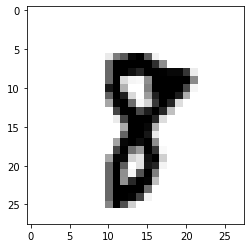

In [13]:
#conferindo o acesso a base de dados
dataiter = iter(trainloader)
imagens, etiquetas = dataiter.next()
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [14]:
print(imagens[0].shape) #verificar as dimensoes do tensor de cada imagem
print(etiquetas[0].shape) #verificar as dimensoes do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [15]:
class Modelo(nn.Module):
    def __init__(self):
       super(Modelo, self).__init__()
       self.linear1 = nn.Linear(28*28, 128) #camada de entrada, 784 neuronios que se ligam a 128
       self.linear2 = nn.Linear(128, 64) #camada interna 1, 128 neuronios que se ligam a 64
       self.linear3 = nn.Linear(64, 10) #camada iterna 2, 64 neuronios que se ligam a 10
       #para a camada de saida nao é necessario definir nasa pois so precisamos peagr o output da cama interna 2

    def forward(self, X):
      X = F.relu(self.linear1(X)) #funcao de ativacao da camada de entrada para a camada interna 1
      X = F.relu(self.linear2(X)) #funcao de ativacaao da camada interna 1 para a camada interna 2
      X = self.linear3(X) #funcao de ativacao da camada interna 2 para a camada de saida, nesse caso f(x) = x
      return F.log_softmax(X, dim=1) #dados utilizados para calcular a perda

In [16]:
def treino(modelo, trainloader, device):

    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) #define a politica de atualizacao dos pesos e das bias
    inicio = time() #timer para saber quanto tempo levou o treino

    criterio = nn.NLLLoss() #definindo o criterio para calcular a perda
    EPOCHS = 10 #numero de epochs que o algoritmo rodara
    modelo.train() #ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0 #inicializacao de perda acumulada da epoch em questao

        for imagens, etiquetas in trainloader:

            imagens = imagens.view(imagens.shape[0], -1) #converteendo as imagens para "vetores" de 28*28 casa para ficarem compativeis com a 
            otimizador.zero_grad() #zerando os gradientes por conta do ciclo anterior

            output = modelo(imagens.to(device)) #colocando os dados do modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) #calculando a perda da epoch em questao

            perda_instantanea.backward() #back propagation a partir da perda

            otimizador.step() #atualizando os pesos e a bias

            perda_acumulada += perda_instantanea.item() #atualizacao da perda acumulada

        else:
            print("Epoch {} - perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader))) 
    print("\nTempo de treino (em minutos) =", (time()-inicio)/60)

In [17]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0 
    for imagem, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)
            #desativar o autograd para acelerar a validacao. Grafos computacionais dinamicos tem um custo alto de processamento 
            with torch.no_grad():
                logps = modelo(img.to(device)) #output do modelo em escala logaritmica

            ps = torch.exp(logps) #converte output para escala normal(lembrando que é um tensor)
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab)) #converte o tensor em um numero, no caso, o umero que o modelo previu 
            etiqueta_certa = etiquetas.numpy()[i]

            if(etiqueta_certa == etiqueta_pred): #compara a previsao com o valor correto
                conta_corretas += 1

            conta_todas += 1

    print("total de imagens testadas =", conta_todas)
    print("\nPrecisao do modelo = {}%". format(conta_corretas*100/conta_todas))

In [18]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device) 

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)